In [1]:
from copy import deepcopy
import os
from unicodedata import decimal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# add imports for randomness
import time
import random

import sys

# Brevitas imports
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant import Int32Bias
import torch.nn.functional as F

# For adaptive learning rate import
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split


## Imports from utils file for my defined noise functions
import sys
#sys.path.append('C:/Users/ashin/source/repos/Cifar10_Pytorch_NoiseAnalysis/Cifar10_Pytorch_NoiseAnalysis/pynq-finn-FPGA/noise_weight_analysis/utils/')
sys.path.append('/opt/finn/pynq-finn-FPGA/noise_weight_analysis/utils')

from noise_functions import random_clust_mask, add_mask_to_model_brevitas, mask_noise_plots_brevitas, add_digital_noise, add_digital_noise_to_model_brevitas, ber_noise_plot_brevitas, add_gaussian_noise, add_gaussian_noise_to_model_brevitas, gaussian_noise_plots_brevitas, test 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cuda


In [3]:
from torchvision import transforms

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply data augmentation to the training dataset
train_set = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)

# Use the validation transform for the validation dataset
val_set =torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=val_transform)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)


a = next(iter(train_loader))
print(a[0].size())
print(len(train_set))

print("Samples in each set: train = %d, test = %s" % (len(train_set), len(train_loader))) 
print("Shape of one input sample: " +  str(train_set[0][0].shape))

## Data Loader
#
# Using PyTorch dataloader we can create a convenient iterator over the dataset that returns batches of data, rather than requiring manual batch creation.

# set batch size
batch_size = 1000

# Create a DataLoader for a training dataset with a batch size of 1000
train_quantized_loader = DataLoader(train_set, batch_size=batch_size)
test_quantized_loader = DataLoader(val_set, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])
50000
Samples in each set: train = 50000, test = 391
Shape of one input sample: torch.Size([3, 32, 32])


In [4]:
count = 0

print("\nDataset Shape:\n-------------------------")
for x, y in train_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break



Dataset Shape:
-------------------------
Input shape for 1 batch: torch.Size([128, 3, 32, 32])
Label shape for 1 batch: torch.Size([128])


In [5]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)

        self.layer1 = qnn.QuantConv2d(3, 32, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer2 = qnn.QuantConv2d(32, 32, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer3 = qnn.QuantConv2d(32, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu3 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer4 = qnn.QuantConv2d(64, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu4 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer5 = qnn.QuantConv2d(64, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu5 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.fc1 = qnn.QuantLinear(64 * 8 * 8, 512, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu6 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.fc2 = qnn.QuantLinear(512, 10, bias=True, weight_bit_width=4, bias_quant=Int32Bias)

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = F.max_pool2d(x, 2)

        x = self.relu3(self.layer3(x))
        x = self.relu4(self.layer4(x))
        x = F.max_pool2d(x, 2)

        x = self.relu5(self.layer5(x))

        x = x.view(x.size(0), -1)

        x = self.relu6(self.fc1(x))
        x = self.fc2(x)

        return x

In [6]:
# Import testing
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import precision_recall_fscore_support

# Initialize the model, optimizer, and criterion
model = CIFAR10CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()

num_epochs = 80
best_test_accuracy = 0
patience = 8
no_improvement_counter = 0

In [7]:
for epoch in range(num_epochs):

    # training phase
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
    
    # Initialize the validation loss
    val_loss = 0
    
    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # accumulate the validation loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
        val_loss /= len(val_loader)  # calculate the average validation loss
    
        # Update the learning rate using the validation loss
        scheduler.step(val_loss)

        test_accuracy = 100 * correct / total
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
        
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), 'test5_model.pth')
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            
        if no_improvement_counter >= patience:
            print("Early stopping")
            break

        print('Epoch [{}/{}], Test Accuracy: {:.2f}%, Precision: {:.2f}, Recall: {:.2f}, F1 score: {:.2f}'.format(epoch+1, num_epochs, test_accuracy, precision, recall, f1))


Epoch [1/80], Step [100/391], Loss: 1.8131
Epoch [1/80], Step [200/391], Loss: 1.5027
Epoch [1/80], Step [300/391], Loss: 1.4158
Epoch [1/80], Test Accuracy: 48.21%, Precision: 0.51, Recall: 0.48, F1 score: 0.47
Epoch [2/80], Step [100/391], Loss: 1.4813
Epoch [2/80], Step [200/391], Loss: 1.3197
Epoch [2/80], Step [300/391], Loss: 1.2305
Epoch [2/80], Test Accuracy: 57.73%, Precision: 0.58, Recall: 0.58, F1 score: 0.56
Epoch [3/80], Step [100/391], Loss: 1.1360
Epoch [3/80], Step [200/391], Loss: 1.0369
Epoch [3/80], Step [300/391], Loss: 1.1374
Epoch [3/80], Test Accuracy: 65.70%, Precision: 0.66, Recall: 0.66, F1 score: 0.65
Epoch [4/80], Step [100/391], Loss: 0.8880
Epoch [4/80], Step [200/391], Loss: 1.1040
Epoch [4/80], Step [300/391], Loss: 0.7543
Epoch [4/80], Test Accuracy: 69.28%, Precision: 0.70, Recall: 0.69, F1 score: 0.69
Epoch [5/80], Step [100/391], Loss: 0.8254
Epoch [5/80], Step [200/391], Loss: 1.1189
Epoch [5/80], Step [300/391], Loss: 0.7680
Epoch [5/80], Test Accu

Epoch [39/80], Step [100/391], Loss: 0.2163
Epoch [39/80], Step [200/391], Loss: 0.1943
Epoch [39/80], Step [300/391], Loss: 0.2278
Epoch [39/80], Test Accuracy: 84.99%, Precision: 0.85, Recall: 0.85, F1 score: 0.85
Epoch [40/80], Step [100/391], Loss: 0.2281
Epoch [40/80], Step [200/391], Loss: 0.1769
Epoch [40/80], Step [300/391], Loss: 0.2319
Epoch [40/80], Test Accuracy: 85.07%, Precision: 0.85, Recall: 0.85, F1 score: 0.85
Epoch [41/80], Step [100/391], Loss: 0.2288
Epoch [41/80], Step [200/391], Loss: 0.2300
Epoch [41/80], Step [300/391], Loss: 0.1601
Epoch [41/80], Test Accuracy: 85.12%, Precision: 0.85, Recall: 0.85, F1 score: 0.85
Epoch [42/80], Step [100/391], Loss: 0.2610
Epoch [42/80], Step [200/391], Loss: 0.2123
Epoch [42/80], Step [300/391], Loss: 0.2205
Epoch [42/80], Test Accuracy: 84.86%, Precision: 0.85, Recall: 0.85, F1 score: 0.85
Epoch [43/80], Step [100/391], Loss: 0.1595
Epoch [43/80], Step [200/391], Loss: 0.1651
Epoch [43/80], Step [300/391], Loss: 0.2504
Epoc

In [8]:
# Print the best test accuracy
print("The final best test accuracy is: {:.2f}%".format(best_test_accuracy))

The final best test accuracy is: 85.71%


In [9]:
trained_state_dict = model.state_dict()

## Saving Model

In [10]:
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_test_accuracy': best_test_accuracy,
        'epoch': epoch
        }, 'test5_model.pth')
    no_improvement_counter = 0


In [11]:
# Create an instance of your neural network model
model = CIFAR10CNN().to(device)

# Load the saved state dictionary from file
state_dict = torch.load('test5_model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)


<All keys matched successfully>

In [12]:
## Digital Noise with BER
layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'fc1', 'fc2']
ber_vals = [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1]
perturbations = 10

ber_noise_plot_brevitas(perturbations, layer_names, ber_vals, model, device, test_quantized_loader)

BER Value: 1e-06	Average Accuracy: 85.71000000000001
BER Value: 1e-05	Average Accuracy: 85.71000000000001
BER Value: 0.0001	Average Accuracy: 85.71000000000001
BER Value: 0.001	Average Accuracy: 84.409
BER Value: 0.01	Average Accuracy: 80.861
BER Value: 0.1	Average Accuracy: 44.628
Done with Plot layer1
BER Value: 1e-06	Average Accuracy: 85.71000000000001
BER Value: 1e-05	Average Accuracy: 85.63500000000002
BER Value: 0.0001	Average Accuracy: 84.876
BER Value: 0.001	Average Accuracy: 82.511
BER Value: 0.01	Average Accuracy: 76.761
BER Value: 0.1	Average Accuracy: 36.471999999999994
Done with Plot layer2
BER Value: 1e-06	Average Accuracy: 85.71000000000001
BER Value: 1e-05	Average Accuracy: 85.71000000000001
BER Value: 0.0001	Average Accuracy: 84.771
BER Value: 0.001	Average Accuracy: 84.22699999999999
BER Value: 0.01	Average Accuracy: 82.31
BER Value: 0.1	Average Accuracy: 55.501
Done with Plot layer3
BER Value: 1e-06	Average Accuracy: 85.65
BER Value: 1e-05	Average Accuracy: 85.597000

<Figure size 640x480 with 0 Axes>

Sigma Value: 0.0, Average Accuracy: 85.71000000000001%
Sigma Value: 0.02, Average Accuracy: 84.37100000000001%
Sigma Value: 0.04, Average Accuracy: 81.851%
Sigma Value: 0.06, Average Accuracy: 77.513%
Sigma Value: 0.08, Average Accuracy: 70.806%
Sigma Value: 0.1, Average Accuracy: 58.03399999999999%
Sigma Value: 0.12, Average Accuracy: 51.081%
Sigma Value: 0.14, Average Accuracy: 44.733%
Sigma Value: 0.16, Average Accuracy: 34.652%
Sigma Value: 0.18, Average Accuracy: 33.747%
Sigma Value: 0.2, Average Accuracy: 25.451%
Done with Plot layer1
Sigma Value: 0.0, Average Accuracy: 85.71000000000001%
Sigma Value: 0.02, Average Accuracy: 84.74600000000001%
Sigma Value: 0.04, Average Accuracy: 82.83399999999999%
Sigma Value: 0.06, Average Accuracy: 77.449%
Sigma Value: 0.08, Average Accuracy: 70.811%
Sigma Value: 0.1, Average Accuracy: 52.967999999999996%
Sigma Value: 0.12, Average Accuracy: 48.09400000000001%
Sigma Value: 0.14, Average Accuracy: 38.538%
Sigma Value: 0.16, Average Accuracy: 32

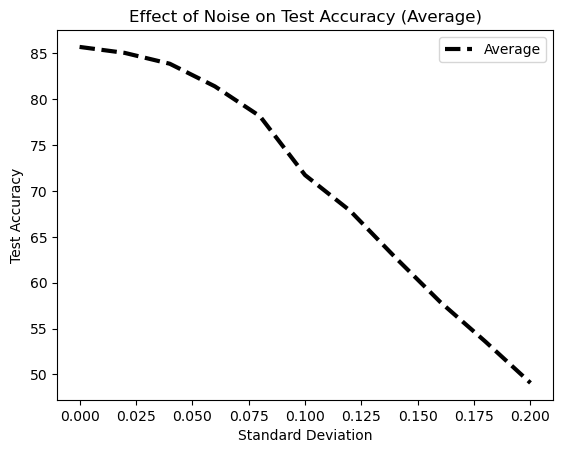

<Figure size 640x480 with 0 Axes>

In [13]:
## Gaussian Noise
sigma_vector = np.linspace(0, 0.2, 11)

gaussian_noise_plots_brevitas(perturbations, layer_names, sigma_vector, model, device, test_quantized_loader)